# Working with annual USGS data

In this exercise we will pull in annual peak flow data from the USGS gage [03171000 NEW RIVER AT RADFORD, VA](https://waterdata.usgs.gov/nwis/uv?site_no=03171000) to explore and analyze. Note, "annual" is based on the water year (October 1 - September 30) and not the calender year (January 1 - December 31).

## Load in the needed packages

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

# %matplotlib inline
import matplotlib.pyplot as plt
%matplotlib widget
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display 

## Load, condition, and plot the data

Let's load in the csv file we created into a Pandas dataframe that we will call ```Qp``` and display the dataframe

In [2]:
datafile = 'NewRiver_annual_peak.csv'
Qp = pd.read_csv(datafile)
display(Qp)

,agency_cd,site_no,peak_dt,peak_va,gage_ht
0,USGS,3171000,1878-09-15,217000,37.40
1,USGS,3171000,1896-04-01,52400,13.00
2,USGS,3171000,1897-02-22,67200,16.00
3,USGS,3171000,1898-09-23,37200,9.60
4,USGS,3171000,1899-03-05,50600,12.60
...,...,...,...,...,...
122,USGS,3171000,2017-04-24,61800,16.78
123,USGS,3171000,2018-09-17,59400,16.30
124,USGS,3171000,2018-10-12,109000,23.83
125,USGS,3171000,2020-05-21,93500,21.71


Let's look at the data types

In [3]:
Qp.dtypes

agency_cd     object
site_no        int64
peak_dt       object
peak_va        int64
gage_ht      float64
dtype: object

In this series we don't need to combine any columns into a single date-time column. However, its worth chaning ```peak_dt``` to a datetime variable

In [4]:
Qp['peak_dt'] = pd.to_datetime(Qp['peak_dt'], format='%Y-%m-%d')
Qp.dtypes

agency_cd            object
site_no               int64
peak_dt      datetime64[ns]
peak_va               int64
gage_ht             float64
dtype: object

Now let's plot the peak flows. Because the flows are not connected sequentially in time, we will use markers instad of a line to represent the data in the plot

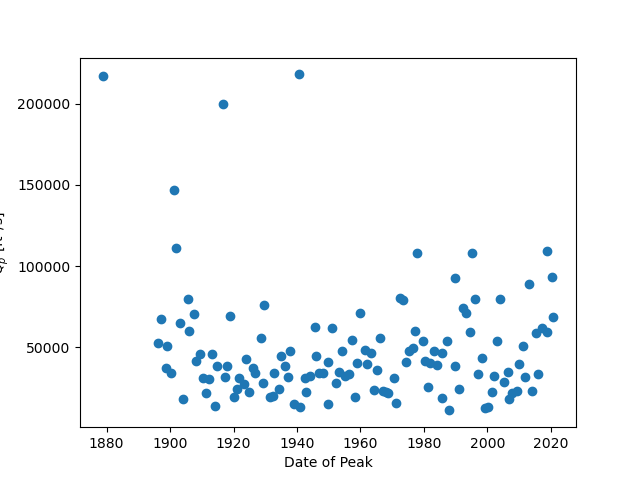

In [5]:
fig, ax1 = plt.subplots()
ax1.plot(Qp['peak_dt'], Qp['peak_va'],'o',alpha=1)
ax1.set_ylabel('$Q_p~\mathrm{[ft^3/s]}$')
ax1.set_xlabel('Date of Peak');

## Accessing specific data

What is the largest flow ever recorded at the station?

In [6]:
max(Qp['peak_va'])

218000

How close was the last major peak to the highest value every recorded?

First let's look at how we find the most recent discharge. We'll first print out all of the values and then print out only the last one.

In [7]:
Qp['peak_va']

0      217000
1       52400
2       67200
3       37200
4       50600
        ...  
122     61800
123     59400
124    109000
125     93500
126     68500
Name: peak_va, Length: 127, dtype: int64

In [8]:
Qp['peak_va'].iloc[-1]

68500

Note that we can also find this value by using ```.iloc[row index,column index]``` on the dataframe ```Qp``` as a whole

In [9]:
Qp.iloc[-1,3]

68500

What day did this most recent peak flow occur?

In [10]:
Qp['peak_dt'].iloc[-1]

Timestamp('2020-11-12 00:00:00')

What how big, in terms of a fraction, was this most recent flow relative to the max ever recorded?

In [11]:
Qp['peak_va'].iloc[-1]/max(Qp['peak_va'])

0.31422018348623854

How big in terms of a percent?

In [12]:
Qp['peak_va'].iloc[-1]/max(Qp['peak_va'])*100

31.422018348623855

On what day did the maximum annual peak flow occur? We previously found the max discharge using ```max(Qp['peak_va'])```, e.g.,

In [13]:
max(Qp['peak_va'])

218000

What we now need to do is to find the time associated with that value. For small datasets we could easily print out the dataframe and look for it.

In [14]:
display(Qp)

,agency_cd,site_no,peak_dt,peak_va,gage_ht
0,USGS,3171000,1878-09-15,217000,37.40
1,USGS,3171000,1896-04-01,52400,13.00
2,USGS,3171000,1897-02-22,67200,16.00
3,USGS,3171000,1898-09-23,37200,9.60
4,USGS,3171000,1899-03-05,50600,12.60
...,...,...,...,...,...
122,USGS,3171000,2017-04-24,61800,16.78
123,USGS,3171000,2018-09-17,59400,16.30
124,USGS,3171000,2018-10-12,109000,23.83
125,USGS,3171000,2020-05-21,93500,21.71


Here we see that we cannot find it directly in the table. We could go back to our interactive plot and find it that way also. Alternatively we can use different methods of find it in the database. One such method is get the index value associated with the max and then use the index with ```.iloc[]``` to find or print out the ```Qp['peak_dt']``` value associated with that index or row.

In [15]:
index = Qp.index[Qp['peak_va']==max(Qp['peak_va'])][0]
Qp['peak_dt'].iloc[index]

Timestamp('1940-08-14 00:00:00')

What was the stage or gage height at that peak flow condition?

In [16]:
Qp['gage_ht'].iloc[index]

35.96

## Flood frequency analysis

How likely is it for a particular flood to occur? What is the 2, 50, 100 year reoccurance interval floods? There are more complex ways to do this analysis, but the simplest to calculate the probability of exeedance in much the same way as we did when looking at thresholds in the 15-min data. For this we can take

$$ P = \frac{m}{n+1}$$

where $P$ is the probability of exceedance for a given flow, $m$ is the flow event rank, and $n$ is the total number of recorded annual flood events. This analysis assumes: that the floods are independent and that the signal is stationary (might not be the case with climate change).

Our reoccurance interval (or return period flood) is $R = 1/P$.

We are going to do a fairly simple analysis to calculate quantities like the 100 year return period flood. We'll do so in a simplified way to make the coding as easy as possible. For more information on flood frequency analysis I'd encourage you to give the following YouTube video from Practical Engineering a watch: [The 100 year Flood Is Not What You Think It Is (Maybe)](https://www.youtube.com/watch?v=EACkiMRT0pc)

Let's start out by simpling sorting or ranking our data from largest to smallest in a new array we'll call ```Q_sorted```

In [17]:
Q_sorted = np.array(sorted(Qp['peak_va'],reverse=True))
Q_sorted

array([218000, 217000, 200000, 147000, 111000, 109000, 108000, 108000,
        93500,  92600,  89300,  80600,  80000,  79900,  79800,  79300,
        76200,  74100,  71000,  70900,  70400,  69400,  68500,  67200,
        65200,  62700,  62200,  61800,  60200,  60000,  59400,  59300,
        58700,  55700,  55700,  54400,  54100,  53900,  53900,  52400,
        50600,  50600,  49600,  48400,  48000,  48000,  47700,  47500,
        46800,  46600,  46200,  46200,  44800,  44400,  43400,  42600,
        41600,  41300,  41000,  40800,  40300,  40100,  40000,  39800,
        39000,  38700,  38600,  38500,  38500,  37200,  37000,  35800,
        34900,  34900,  34500,  34500,  34500,  34000,  34000,  33500,
        33500,  33300,  32500,  32100,  32100,  32000,  32000,  31800,
        31400,  31300,  31000,  31000,  30500,  28700,  28100,  28000,
        27500,  25700,  24400,  24200,  24200,  24000,  23400,  23100,
        22900,  22800,  22800,  22700,  22500,  21900,  21900,  21700,
      

In [18]:
print('The total number of years in our record is', len(Q_sorted))

The total number of years in our record is 127


This means with our analysis we will be able to get up to defining a ```len(Q_sorted)+1``` reoccurance flood. Let's assign a rank and then calculate $P$ and $R$.

In [19]:
n = len(Q_sorted)
rank = np.arange(n)+1
P = rank/(n+1)
R = 1/P

Let's put these all into a dataframe for display purposes. We may also want to save as a ```.csv``` file at some point.

In [20]:
freq_anal = pd.DataFrame({'Rank':rank,'Q_cfs':Q_sorted,'P_exceed':P,'RI':R})
freq_anal

,Rank,Q_cfs,P_exceed,RI
0,1,218000,0.007812,128.000000
1,2,217000,0.015625,64.000000
2,3,200000,0.023438,42.666667
3,4,147000,0.031250,32.000000
4,5,111000,0.039062,25.600000
...,...,...,...,...
122,123,14000,0.960938,1.040650
123,124,13600,0.968750,1.032258
124,125,13200,0.976562,1.024000
125,126,12500,0.984375,1.015873


## Linear interpolation to find particular reoccurance intervals

Let's find the 2, 10, 50 and 100 year storms using simple linear interpolation. Linear interpolation is easy with ```np.interp()```. However,```np.interp()``` assumes that the arrays you are working increase with each step into the array. For the frequency analsysis we sorted the discharge from largest to smallest instead of smallest to largerst. So we will need to do the interpolation on the reverse of the arrays. We can reverse the order of the array using ```[::-1]```.

In [21]:
Q2yr = np.interp(2,R[::-1],Q_sorted[::-1])
Q10yr = np.interp(10,R[::-1],Q_sorted[::-1])
Q50yr = np.interp(50,R[::-1],Q_sorted[::-1])
Q100yr = np.interp(100,R[::-1],Q_sorted[::-1])

print('The 2 yr return period flow is', np.around(Q2yr, decimals = 0),'[cfs]')
print('The 10 yr return period flow is', np.around(Q10yr, decimals = 0),'[cfs]')
print('The 50 yr return period flow is', np.around(Q50yr, decimals = 0),'[cfs]')
print('The 100 yr return period flow is', np.around(Q100yr, decimals = 0),'[cfs]')

The 2 yr return period flow is 39800.0 [cfs]
The 10 yr return period flow is 80112.0 [cfs]
The 50 yr return period flow is 205844.0 [cfs]
The 100 yr return period flow is 217562.0 [cfs]


What is the probability that a 2 year flood will happen in any give year?

In [22]:
1/2

0.5

The value listed above is the probabily that the flow will exceed the 2 year flood in any given year. What is the probabily that the 100 year flood will be exceeded in any given year?

In [23]:
1/100

0.01

Let's say a 100 year flood occurs this year. What is the probability that it will happen next year?

In [24]:
1/100

0.01

What is the average annual peak flow at the New River Gage station according to []()

## Fitting the data and extending it past your data range

Here we plot exceedance probability, $P$ (in terms of percent), vs $Q$ to create a flow exceedance curve

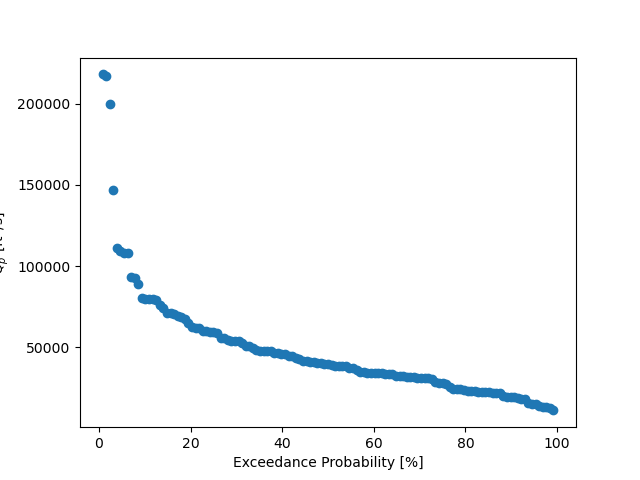

In [25]:
plt.close('all') # close the interactive figures
 
fig, ax1 = plt.subplots()
ax1.plot(P*100, Q_sorted,'o',alpha=1)
ax1.set_ylabel('$Q_p~\mathrm{[ft^3/s]}$')
ax1.set_xlabel('Exceedance Probability [%]');

Now we are going to change the way in which this is plotted so that it looks like a typicaly exceedance probabilty plot. To do this we will reverse the horizontal access so that exceedance probabilty is decreasing to the right and the us log axes.

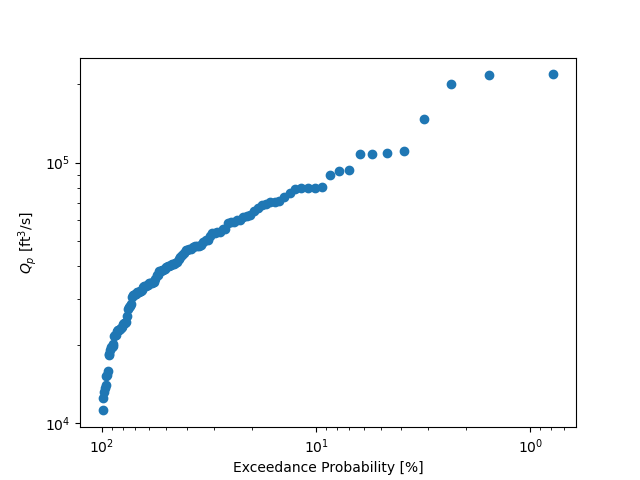

In [26]:
fig, ax1 = plt.subplots()
ax1.plot(P*100, Q_sorted,'o',alpha=1)
ax1.invert_xaxis()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('$Q_p~\mathrm{[ft^3/s]}$')
ax1.set_xlabel('Exceedance Probability [%]');

The form of the plot above is often how annual peak flow events are displayed.

## Fitting an equation to the exceedance curve for extrapolation

At this particular gage station we have over 100 years of recorded peak flow data. This is a lot. At most stations we have far less. Recall that the number of years on record influences the size of reoccurrence interval or return period flow that we can calculate. Let's say we only have 30 years worth of data, but we want to calculate the 100 year or high return period flow for engineering purposes. To do this we would need to fit an equation to the data we have and then use the fit to extrapolate up to higher probabilities. There are different ways to do this, but one of the easiest is to use the Gumbel method. 

The Gumbel method does not require any regression or optimization of fitting coefficients. Instead, it uses the mean or average of the observed discharge values and the standard deviation (a measure of the variation about the average) of the discharge values to estimate the key model or equation inputs. We'll use this method here for that reason. However, note that fitting a log Pearson type III distribution to the data is the approved USGS method for reoccurrence interval prediction. Also, check out the freely available [HEC-SSP](https://www.hec.usace.army.mil/software/hec-ssp/) program from the US Army Corps of Engineers for built-in ways to do the fit and more.

The simple Gumbel method we will use makes use of:

$$ P = 1-\exp[-\exp(-Q^*)] $$

where 

$$ Q^* = \frac{Q-u}{\alpha} $$

and

$$ u = Q_{avg} - 0.5772\alpha $$

Here $Q_{avg}$ is just the mean of the measured discharge values and $\alpha =\sigma_Q\sqrt{6}/pi$ with $\sigma_Q$ being the standard deviation of the discharge values. 

To use this method we need to:
1. first calculate the mean of the discharge values, $Q_{avg}$, and 
2. the standard deviation of the disharge values, $\sigma_Q$.
3. Then we calculate $\alpha$ and $u$. 
4. Next we assume a range of $Q$ values so that we can calculate $Q^*$ and ultimately
5. compute the predicted probabilities of exceedance with $ P = 1-\exp[-\exp(-Q^*)] $

Frist calculate everything needed for calculating $Q^*$

In [27]:
Qavg = np.mean(Q_sorted)
Qsd = np.std(Q_sorted)
alpha = np.sqrt(6)*Qsd/np.pi
u = Qavg - 0.5772*alpha

Now develope the range of discharge values, let's call them $Q_{\text{calc}}$ for which we will calculate $Q^*$ and after $ P = 1-\exp[-\exp(-Q^*)] $.

In [28]:
Qcalc = np.linspace(min(Q_sorted)-0.1*min(Q_sorted),max(Q_sorted)+0.1*max(Q_sorted),200)

No calculate make the calculation and plot the predicted Gumbel function along with the measured data.

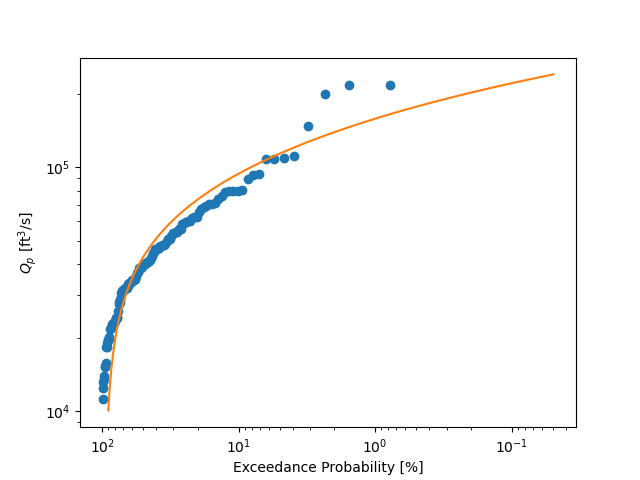

In [29]:
# calculation
Qstar = (Qcalc-u)/alpha
Pcalc = 1-np.exp(-np.exp(-Qstar))

# make the plot and compare with the data
fig, ax1 = plt.subplots()
ax1.plot(P*100, Q_sorted,'o',alpha=1, label='Observations')
ax1.plot(Pcalc*100, Qcalc,alpha=1, label='Theory')
ax1.invert_xaxis()
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('$Q_p~\mathrm{[ft^3/s]}$')
ax1.set_xlabel('Exceedance Probability [%]');

What do you notice about the theoretical prediction when compared to the data? 

Let's look at the same set of data and predictions but just plotted slightly different.

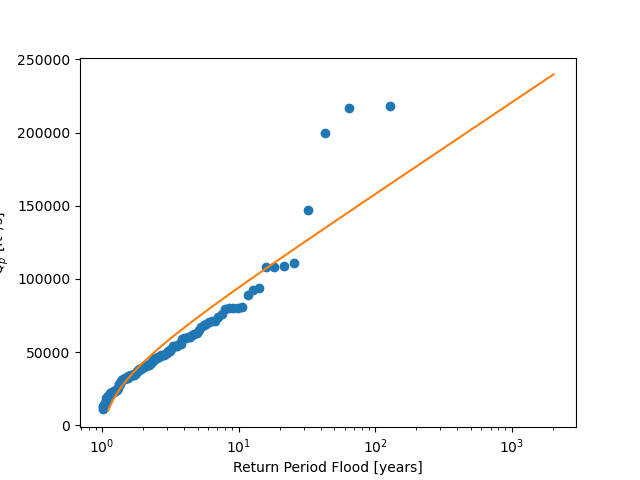

In [30]:
plt.close('all')
fig, ax1 = plt.subplots()
ax1.plot(1/P, Q_sorted,'o',alpha=1, label='Observations')
ax1.plot(1/Pcalc, Qcalc,alpha=1, label='Theory')
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_ylabel('$Q_p~\mathrm{[ft^3/s]}$')
ax1.set_xlabel('Return Period Flood [years]');

Let's compare the 2, 10, 50, and 100 year events we obtained through linear interpolation of the data and those predicted with the Gumbel model. Recall, from the data we have...

In [31]:
print('Linear interpolation of the data gives:')
print('- 2 yr =', np.around(Q2yr, decimals = 0),'[cfs]')
print('- 10 yr =', np.around(Q10yr, decimals = 0),'[cfs]')
print('- 50 yr =', np.around(Q50yr, decimals = 0),'[cfs]')
print('- 100 yr =', np.around(Q100yr, decimals = 0),'[cfs]')

Linear interpolation of the data gives:
- 2 yr = 39800.0 [cfs]
- 10 yr = 80112.0 [cfs]
- 50 yr = 205844.0 [cfs]
- 100 yr = 217562.0 [cfs]


The easiest way to get this from the Gumbel prediction is to again do interpolation

In [32]:
Tcalc = 1/Pcalc

Q2yrG = np.interp(2,Tcalc,Qcalc)
Q10yrG = np.interp(10,Tcalc,Qcalc)
Q50yrG = np.interp(50,Tcalc,Qcalc)
Q100yrG = np.interp(100,Tcalc,Qcalc)
Q500yrG = np.interp(500,Tcalc,Qcalc)

print('Return period flows estimates')
print('--------------------------------------')
print('        data      |   Gumbel    ')
print('--------------------------------------')
print('2 yr   =', np.around(Q2yr, decimals = 0), ' |',np.around(Q2yrG, decimals = 0),'[cfs]')
print('10 yr  =', np.around(Q10yr, decimals = 0), ' |',np.around(Q10yrG, decimals = 0),'[cfs]')
print('50 yr  =', np.around(Q50yr, decimals = 0), '|',np.around(Q50yrG, decimals = 0),'[cfs]')
print('100 yr =', np.around(Q100yr, decimals = 0), '|',np.around(Q100yrG, decimals = 0),'[cfs]')
print('500 yr =', 'NA', '      |',np.around(Q500yrG, decimals = 0),'[cfs]')

Return period flows estimates
--------------------------------------
        data      |   Gumbel    
--------------------------------------
2 yr   = 39800.0  | 42812.0 [cfs]
10 yr  = 80112.0  | 94029.0 [cfs]
50 yr  = 205844.0 | 138929.0 [cfs]
100 yr = 217562.0 | 157915.0 [cfs]
500 yr = NA       | 201779.0 [cfs]


Again, what do you notice?

## Bankfull Flow

In sediment transport we often assume that the river geometry and sediment properties are being set by a certain sort of average "formative" discharge that we take to be approximately equivalent to the so-called "bankfull flow." Bankfull flow is the discharge condition for which water, on average, is at the top of the banks. There are different ways to estimate the bankfull flow condition, but one common way to estimate it is to relate it to the 1.5 or 2-year return period flow. Using this definition, what discharge would you take the bankfull flow condition?

In [33]:
Q1_5yr = np.interp(1.5,R[::-1],Q_sorted[::-1])
print('the 1.5 year flow based on the measurements is:', Q1_5yr)

the 1.5 year flow based on the measurements is: 32066.40625


Given this the 1.5 and 2 year flows, we might expect the $Q_{\text{bankfull}}$ to be between 30,000 to 40,000 cfs.